# Problem statement

Q: How much does it cost to cool a skyscraper in the summer?
A: A lot! And not just in dollars, but in environmental impact.

Thankfully, significant investments are being made to improve building efficiencies to reduce costs and emissions. The question is, are the improvements working? That’s where you come in. Under pay-for-performance financing, the building owner makes payments based on the difference between their real energy consumption and what they would have used without any retrofits. The latter values have to come from a model. Current methods of estimation are fragmented and do not scale well. Some assume a specific meter type or don’t work with different building types.

In this competition, you’ll develop accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe. With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

### Note about codestyle

In Jupyter notebooks, the emphasis is on quick experimentation. The quality of the code is not what we optimize for. So when "productionizing" this notebook, take everything with a grain of salt and rethink the structure of the code.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold

sns.set_style('darkgrid')

In [2]:
%matplotlib inline

Input data is available on the file system in `../input/ashrae-energy-prediction`. Let's just list it first.

In [3]:
DATA_DIR = '../input/ashrae-energy-prediction'
print(os.listdir(DATA_DIR))

['weather_test.csv', 'weather_train.csv', 'test.csv', 'train.csv', 'building_metadata.csv', 'sample_submission.csv']


# Description of files

(pasted from https://www.kaggle.com/c/ashrae-energy-prediction/data)

### train.csv
* `building_id` - Foreign key for the building metadata.
* `meter` - The meter id code. Read as `{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}`. Not every building has all meter types.
* `timestamp` - When the measurement was taken
* `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

### building_meta.csv
* `site_id` - Foreign key for the weather files.
* `building_id` - Foreign key for training.csv
* `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* `square_feet` - Gross floor area of the building
* `year_built` - Year building was opened
* `floor_count` - Number of floors of the building

### weather_[train/test].csv
Weather data from a meteorological station as close as possible to the site.

* `site_id`
* `air_temperature` - Degrees Celsius
* `cloud_coverage` - Portion of the sky covered in clouds, in oktas
* `dew_temperature` - Degrees Celsius
* `precip_depth_1_hr` - Millimeters
* `sea_level_pressure` - Millibar/hectopascals
* `wind_direction` - Compass direction (0-360)
* `wind_speed` - Meters per second

### test.csv
The submission files use row numbers for ID codes in order to save space on the file uploads. `test.csv` has no feature data; it exists so you can get your predictions into the correct order.

* `row_id` - Row id for your submission file
* `building_id` - Building id code
* `meter` - The meter id code
* `timestamp` - Timestamps for the test data period

# Load up the data

In [4]:
# Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def load_df(fname):
    df = pd.read_csv(os.path.join(DATA_DIR, fname))
    if 'timestamp' in df.columns:
        # I guess fortunately all timestamp columns are called `timestamp`.
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [5]:
train_df = reduce_mem_usage(load_df('train.csv'))
building_metadata_df = reduce_mem_usage(load_df('building_metadata.csv'))
weather_train_df = reduce_mem_usage(load_df('weather_train.csv'))

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)


# Exploratory data analysis, minor cleanup and feature generation

In [6]:
def describe_df(df):
    print('Shape of data: ', df.shape)
    print('\nBasic info:')
    print(df.info())
    print('\nQuick peek at the data:')
    print(df.head())
    print('\nBasic description of the data:')
    print(df.describe())
    print('\nLooking at NAs')
    print(df.isna().sum())

## Analysis: `train_df`

In [7]:
describe_df(train_df)

Shape of data:  (20216100, 4)

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int16
meter            int8
timestamp        datetime64[ns]
meter_reading    float32
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB
None

Quick peek at the data:
   building_id  meter  timestamp  meter_reading
0            0      0 2016-01-01            0.0
1            1      0 2016-01-01            0.0
2            2      0 2016-01-01            0.0
3            3      0 2016-01-01            0.0
4            4      0 2016-01-01            0.0

Basic description of the data:
        building_id         meter  meter_reading
count  2.021610e+07  2.021610e+07   2.021610e+07
mean   7.992780e+02  6.624412e-01   2.117122e+03
std    4.269133e+02  9.309921e-01   1.532356e+05
min    0.000000e+00  0.000000e+00   0.000000e+00
25%    3.930000e+02  0.000000e+00   1.830000e+01
50%    8.950000e+

There are no NAs in `train_df`, so that's nice. The timestamps have been treated well. The memory consumption is modest, so there's no need to mess around with that.

It's worth looking at the meter readings as timeseries data.

In [8]:
# The duration of the training data
train_df['timestamp'].min(), train_df['timestamp'].max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2016-12-31 23:00:00'))

/Users/abhinchhabra/.virtualenvs/data/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


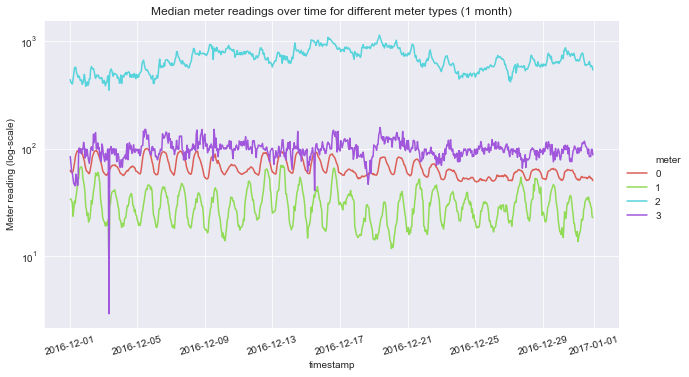

In [9]:
sns.relplot(x='timestamp', y='meter_reading', hue='meter', kind='line', 
            palette=sns.color_palette('hls', 4), aspect=16/9,
            data=(train_df[train_df['timestamp'] > pd.to_datetime('2016-12-01')]
                  .groupby(by=['meter', 'timestamp'])
                  .agg({'meter_reading': 'median'}).reset_index()))
plt.xticks(rotation=15)
plt.title('Median meter readings over time for different meter types (1 month)')
plt.gca().set(yscale='log')
plt.ylabel('Meter reading (log-scale)')
plt.show()

> Note: The `meter_reading` column is in log-scale above. The outputs of meter type `2` are much higher than the rest, so it's easier to see patterns in log-scale.

In the plot above, we can see that the meter type is obviously an important feature. In addition, clearly the `meter_reading` has plenty of seasonality. The most evident examples of seasonality here are based on time of day and day of week and that seasonality is different for different meter types.

For example, notice that meter `0` is clearly affected by weekend vs. weekday dynamics more so than other meter types. There are probably also monthly seasonal effects based on heating needs being different in winter vs. summer, although that's not visible in the graph above. To see that aspect of seasonality look at the plot below.

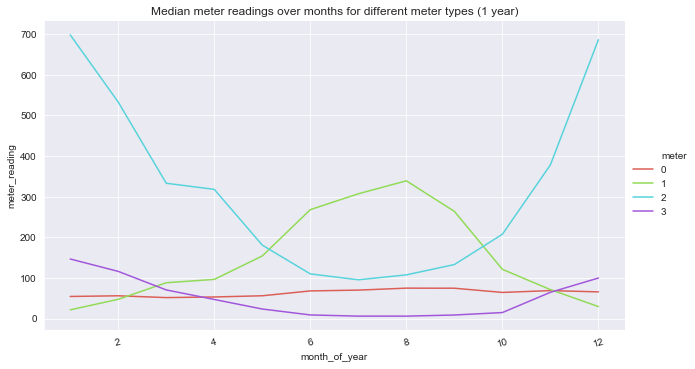

In [10]:
sns.relplot(x='month_of_year', y='meter_reading', hue='meter', kind='line', 
            palette=sns.color_palette('hls', 4), aspect=16/9,
            data=(train_df
                  .assign(month_of_year=train_df['timestamp'].dt.month)
                  .groupby(by=['meter', 'month_of_year'])
                  .agg({'meter_reading': 'median'}).reset_index()))
plt.xticks(rotation=15)
plt.title('Median meter readings over months for different meter types (1 year)')
plt.show()
plt.close()

So far, we've concluded that the meter type, the hour of day, the day of week, the day of year are potentially useful features. So let's add those to the `train_df` dataframe.

## Feature generation: `train_df`

In [11]:
train_df = train_df.assign(hour_of_day=train_df['timestamp'].dt.hour, 
                           day_of_week=train_df['timestamp'].dt.dayofweek,
                           day_of_year=train_df['timestamp'].dt.dayofyear)

## Analysis: `building_metadata.csv`

The `train_df` dataframe had a `building_id` column that we never investigated. Let's do that now, combined with the `building_metadata.csv` file.

In [12]:
describe_df(building_metadata_df)

Shape of data:  (1449, 6)

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int8
building_id    1449 non-null int16
primary_use    1449 non-null object
square_feet    1449 non-null int32
year_built     675 non-null float16
floor_count    355 non-null float16
dtypes: float16(2), int16(1), int32(1), int8(1), object(1)
memory usage: 27.0+ KB
None

Quick peek at the data:
   site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

Basic description of the data:
           site_id  building_id    square_feet  year_bu

One of the problems here is that the columns `year_built` and `floor_count` have plenty of null values. For now, I'm planning to leave them as is. Lightgbm can handle null values, so we'll rely on that for now. 

It would be interesting to see how both `square_feet`, `primary_use` and `year_built` influence `energy_consumption`

### Relationship between `square_feet` and energy consumption

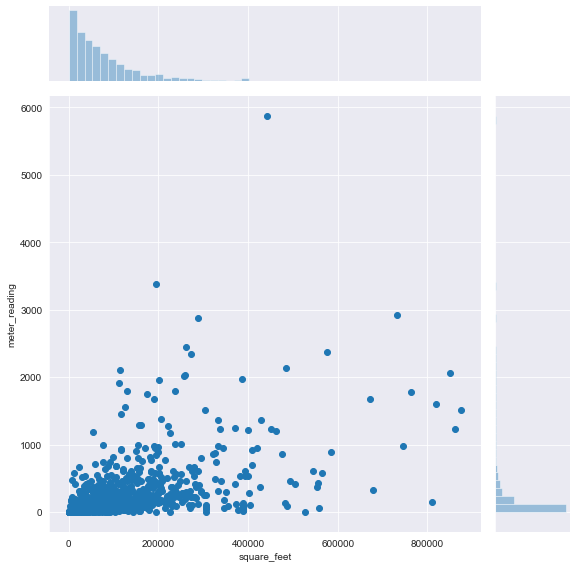

In [13]:
g = sns.jointplot(x='square_feet', y='meter_reading', height=8,
                  data=(train_df.groupby(by='building_id')
                        .agg({'meter_reading': 'median'})
                        .join(building_metadata_df, on=['building_id'])))
plt.show()
plt.close()

It's interesting that there doesn't seem to be much of a linear relationship between `square_feet` and the `meter_reading`. What's more interesting is that the relationship is more evident in log-log space.

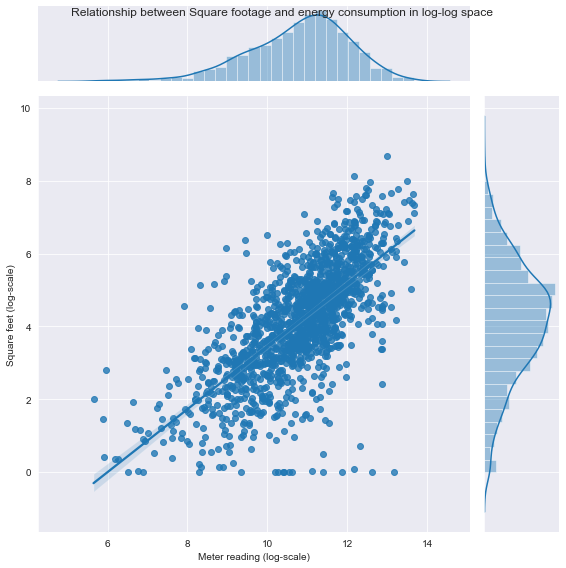

In [14]:
g = sns.jointplot(x='square_feet', y='meter_reading', height=8, kind='reg',
                  data=(train_df.groupby(by='building_id')
                        .agg({'meter_reading': 'median'})
                        .join(building_metadata_df, on=['building_id'])
                        .pipe(lambda df: df.assign(meter_reading=np.log1p(df.meter_reading),
                                                   square_feet=np.log1p(df.square_feet)))))
g.ax_joint.set_xlabel('Meter reading (log-scale)')
g.ax_joint.set_ylabel('Square feet (log-scale)')
g.fig.suptitle('Relationship between Square footage and energy consumption in log-log space')
plt.show()
plt.close()

### Relationship between `primary_use` and energy consumption

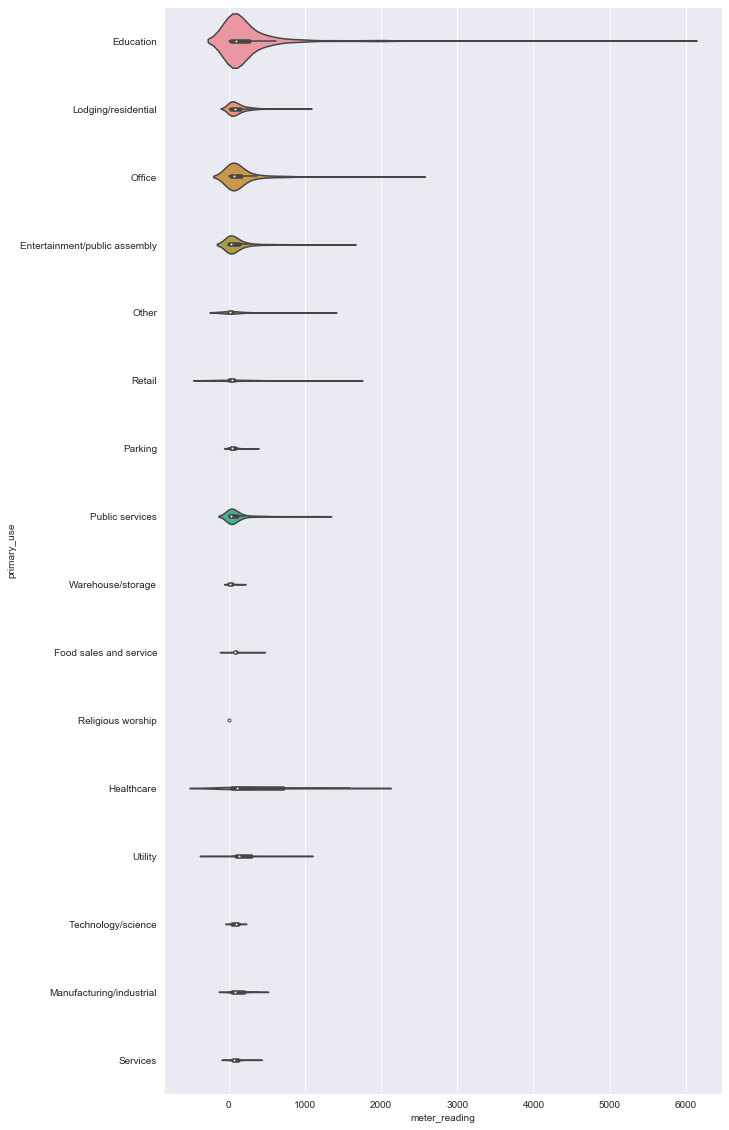

In [15]:
fig = plt.figure(figsize=(10, 20))
sns.violinplot(x='meter_reading', y='primary_use', orient='h', scale='count',
               data=(train_df.groupby(by='building_id')
                     .agg({'meter_reading': 'median'})
                     .join(building_metadata_df, on=['building_id'])))
plt.show()
plt.close()

As could have been expected, the distributions of energy consumption for various types of buildings is different. Since the violin plots are scaled by the count of datapoints, it means that most of the data in the training set is for education buildings.

### Relationship between `year_built` and energy consumption

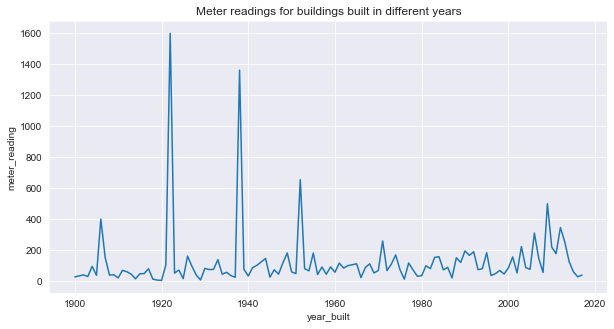

In [16]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='year_built', y='meter_reading',
             data=(train_df
                   .merge(building_metadata_df, on=['building_id'])
                   .groupby(by='year_built')
                   .agg({'meter_reading': 'median'})
                   .reset_index()))
plt.title('Meter readings for buildings built in different years')
plt.show()
plt.close()

Clearly, the median meter reading for buildings built during different years is very different. So of course the year_built is an important feature. Perhaps it would be appropriate to keep it a categorical feature. 

## Feature generation: `building_metadata.csv`

For now, we definitely want to encode the 2 categorical variables: `year_built` and `primary_use`. We also want to log-transform the `square_feet` column because of our previous analysis.

In [17]:
building_metadata_enc = {
    'year_built': LabelEncoder(),
    'primary_use': LabelEncoder(),
}
building_metadata_df['year_built_enc'] = (building_metadata_enc['year_built']
                                          .fit_transform(building_metadata_df['year_built']))
building_metadata_df['primary_use_enc'] = (building_metadata_enc['primary_use']
                                           .fit_transform(building_metadata_df['primary_use']))

In [18]:
building_metadata_df['square_feet_log'] = np.log1p(building_metadata_df['square_feet'])

## Analysis: `weather_train.csv`

In [19]:
describe_df(weather_train_df)

Shape of data:  (139773, 9)

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float16
cloud_coverage        70600 non-null float16
dew_temperature       139660 non-null float16
precip_depth_1_hr     89484 non-null float16
sea_level_pressure    129155 non-null float16
wind_direction        133505 non-null float16
wind_speed            139469 non-null float16
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 3.1 MB
None

Quick peek at the data:
   site_id           timestamp  air_temperature  cloud_coverage  \
0        0 2016-01-01 00:00:00        25.000000             6.0   
1        0 2016-01-01 01:00:00        24.406250             NaN   
2        0 2016-01-01 02:00:00        22.796875             2.0   
3        0 2016-01-01 03:00:00        21.093750             2.0   


There are lot of nans here. We might have to do some imputation for weather. Plus, we don't even know if all the hours starting from the smallest in the dataframe to the largest have values here. We should check that out first.

### Checking time-gaps in weather data

In [20]:
training_datetime_range = pd.date_range(start=train_df['timestamp'].min(), end=train_df['timestamp'].max(), freq='H')
sites = building_metadata_df['site_id'].unique()
weather_train_idx = pd.MultiIndex.from_product([training_datetime_range, sites], names=['timestamp', 'site_id'])

weather_train_idx

MultiIndex([('2016-01-01 00:00:00',  0),
            ('2016-01-01 00:00:00',  1),
            ('2016-01-01 00:00:00',  2),
            ('2016-01-01 00:00:00',  3),
            ('2016-01-01 00:00:00',  4),
            ('2016-01-01 00:00:00',  5),
            ('2016-01-01 00:00:00',  6),
            ('2016-01-01 00:00:00',  7),
            ('2016-01-01 00:00:00',  8),
            ('2016-01-01 00:00:00',  9),
            ...
            ('2016-12-31 23:00:00',  6),
            ('2016-12-31 23:00:00',  7),
            ('2016-12-31 23:00:00',  8),
            ('2016-12-31 23:00:00',  9),
            ('2016-12-31 23:00:00', 10),
            ('2016-12-31 23:00:00', 11),
            ('2016-12-31 23:00:00', 12),
            ('2016-12-31 23:00:00', 13),
            ('2016-12-31 23:00:00', 14),
            ('2016-12-31 23:00:00', 15)],
           names=['timestamp', 'site_id'], length=140544)

As you can see, the `weather_train_idx` index has a length larger than that of `weather_train_df`. This implies that there are gaps in the weather information. Let's expand the `weather_train_df` dataframe to account for those gaps first.

In [21]:
weather_train_df = pd.merge(left=pd.DataFrame(index=weather_train_idx).reset_index(), 
                            right=weather_train_df, how='left', on=['timestamp', 'site_id'])

In [22]:
weather_train_df

,timestamp,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,0,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,2016-01-01 00:00:00,1,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609
2,2016-01-01 00:00:00,2,15.601562,6.0,-5.601562,NaN,1015.5,270.0,3.599609
3,2016-01-01 00:00:00,3,10.000000,8.0,2.199219,NaN,1021.0,350.0,4.101562
4,2016-01-01 00:00:00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
140539,2016-12-31 23:00:00,11,-9.601562,NaN,-10.796875,5.0,1004.5,70.0,4.101562
140540,2016-12-31 23:00:00,12,6.500000,8.0,5.300781,NaN,1019.5,340.0,6.000000
140541,2016-12-31 23:00:00,13,-5.601562,4.0,-11.101562,0.0,1010.0,240.0,3.599609
140542,2016-12-31 23:00:00,14,6.101562,NaN,-6.699219,-1.0,1012.5,190.0,9.796875


### Imputing weather information

We can use `interpolate` to impute values. We do so within the context of each `site_id`.

In [23]:
weather_train_df = pd.concat([site_weather_train_df.sort_values('timestamp').interpolate(limit_direction='both')
                             for _, site_weather_train_df in weather_train_df.groupby('site_id')])

In [24]:
weather_train_df

,timestamp,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,0,25.000000,6.0,20.000000,-1.0,1019.5,0.0,0.000000
16,2016-01-01 01:00:00,0,24.406250,4.0,21.093750,-1.0,1020.0,70.0,1.500000
32,2016-01-01 02:00:00,0,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000
48,2016-01-01 03:00:00,0,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000
64,2016-01-01 04:00:00,0,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609
...,...,...,...,...,...,...,...,...,...
140479,2016-12-31 19:00:00,15,3.000000,1.5,-8.000000,-1.0,1007.5,180.0,5.699219
140495,2016-12-31 20:00:00,15,2.800781,2.0,-8.898438,-1.0,1007.5,180.0,7.699219
140511,2016-12-31 21:00:00,15,2.800781,2.0,-7.199219,-1.0,1007.5,180.0,5.101562
140527,2016-12-31 22:00:00,15,2.199219,2.0,-6.699219,-1.0,1008.0,170.0,4.601562


In [25]:
describe_df(weather_train_df)

Shape of data:  (140544, 9)

Basic info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 140544 entries, 0 to 140543
Data columns (total 9 columns):
timestamp             140544 non-null datetime64[ns]
site_id               140544 non-null int64
air_temperature       140544 non-null float16
cloud_coverage        122976 non-null float16
dew_temperature       140544 non-null float16
precip_depth_1_hr     114192 non-null float16
sea_level_pressure    131760 non-null float16
wind_direction        140544 non-null float16
wind_speed            140544 non-null float16
dtypes: datetime64[ns](1), float16(7), int64(1)
memory usage: 5.1 MB
None

Quick peek at the data:
             timestamp  site_id  air_temperature  cloud_coverage  \
0  2016-01-01 00:00:00        0        25.000000             6.0   
16 2016-01-01 01:00:00        0        24.406250             4.0   
32 2016-01-01 02:00:00        0        22.796875             2.0   
48 2016-01-01 03:00:00        0        21.093750           

Many of the columns still have plenty of NAs. The only explanation for it is that this must be for sites that have no data for those columns. Let's just double check that.

In [26]:
weather_train_df[weather_train_df['cloud_coverage'].isna()]['site_id'].unique()

array([ 7, 11])

In [27]:
print(weather_train_df[weather_train_df['site_id'] == 7]['cloud_coverage'].shape)
print(weather_train_df[weather_train_df['site_id'] == 7]['cloud_coverage'].isna().sum())
print(weather_train_df[weather_train_df['site_id'] == 11]['cloud_coverage'].shape)
print(weather_train_df[weather_train_df['site_id'] == 11]['cloud_coverage'].isna().sum())

(8784,)
8784
(8784,)
8784


It's no wonder that all the number of NAs in the post-interpolation `weather_train_df` are multiples of `8784`. We'll just not use these columns for now in the training data.

# Merge all the dataframes

Before we do the analysis of the relationship of the various weather parameters to the meter reading, it might be beneficial to merge the dataframes, so we can get ahead of this expensive operation.

In [28]:
merged_df = (train_df
             .merge(building_metadata_df, on=['building_id'])
             .merge(weather_train_df, on=['site_id', 'timestamp']))

In [29]:
merged_df.head()

,building_id,meter,timestamp,meter_reading,hour_of_day,day_of_week,day_of_year,site_id,primary_use,square_feet,...,year_built_enc,primary_use_enc,square_feet_log,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,4,1,0,Education,7432,...,106,0,8.913685,25.0,6.0,20.0,-1.0,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,4,1,0,Education,2720,...,102,0,7.908755,25.0,6.0,20.0,-1.0,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,4,1,0,Education,5376,...,89,0,8.589886,25.0,6.0,20.0,-1.0,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,4,1,0,Education,23685,...,100,0,10.072639,25.0,6.0,20.0,-1.0,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,4,1,0,Education,116607,...,73,0,11.666573,25.0,6.0,20.0,-1.0,1019.5,0.0,0.0


### Relationship between `air_temperature` and `meter_reading`

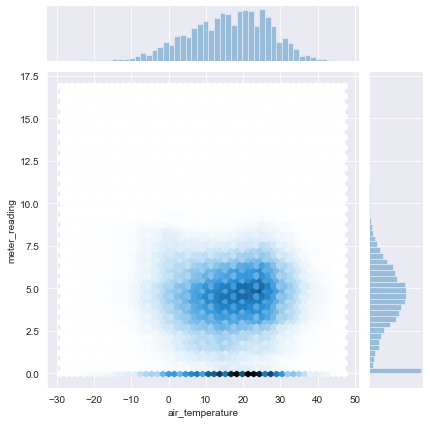

In [30]:
sns.jointplot(data=merged_df.assign(meter_reading=np.log1p(merged_df.meter_reading)), kind='hex',
              x='air_temperature', y='meter_reading')
plt.show()
plt.close()

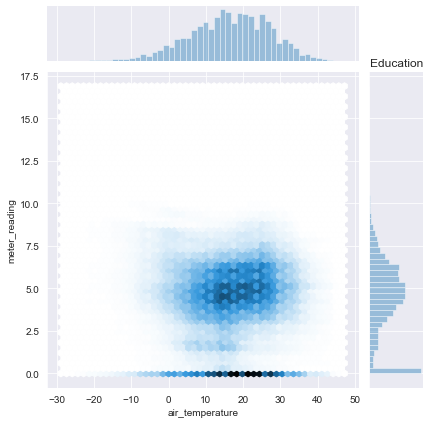

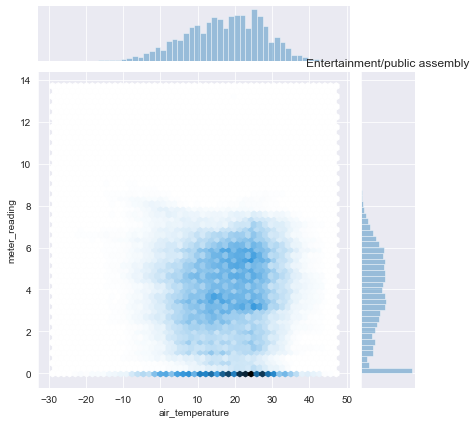

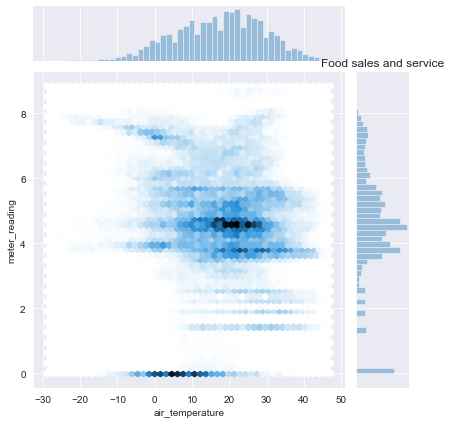

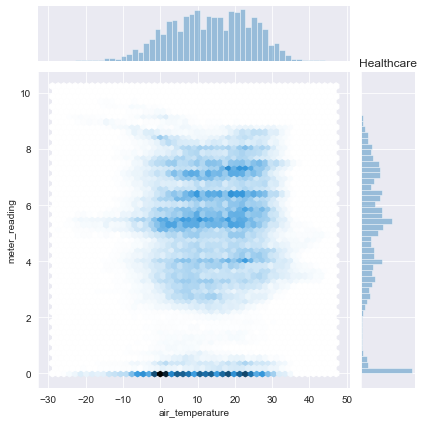

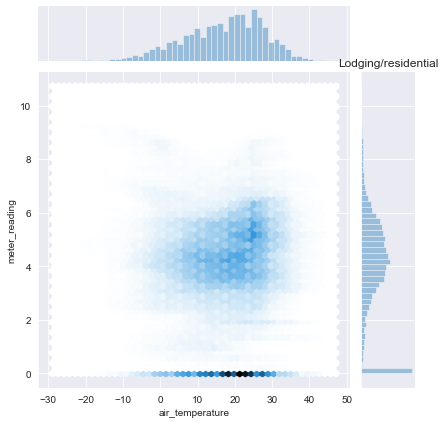

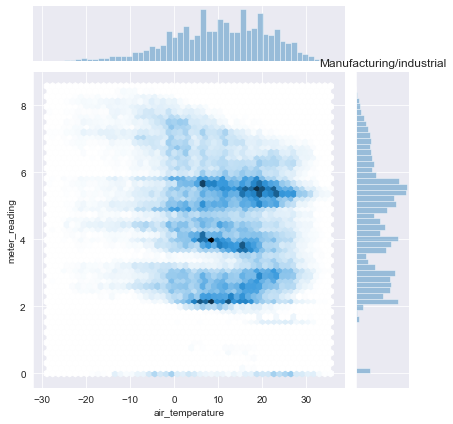

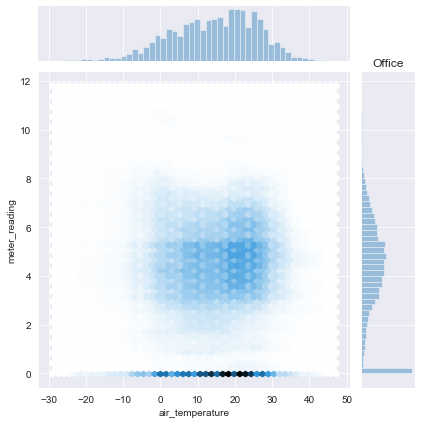

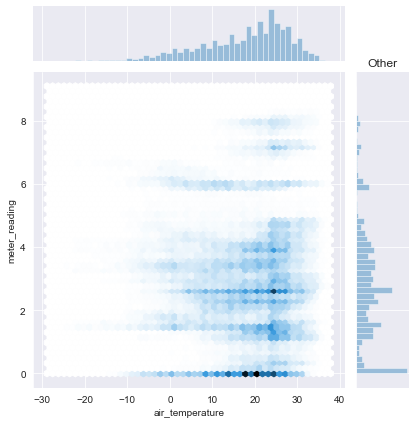

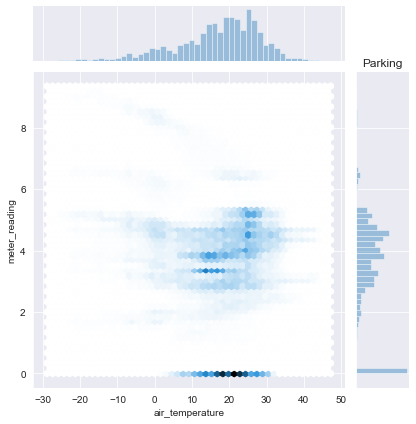

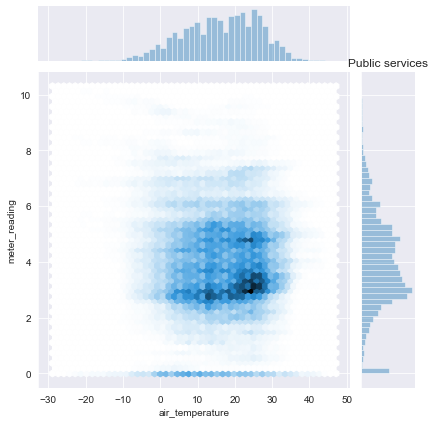

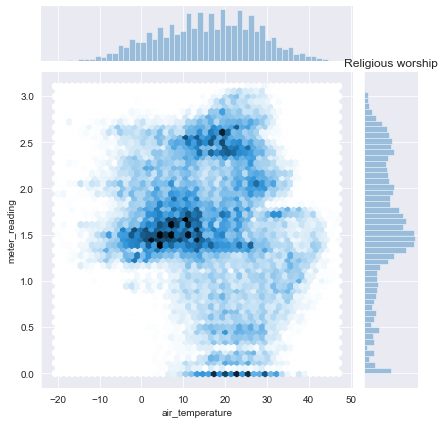

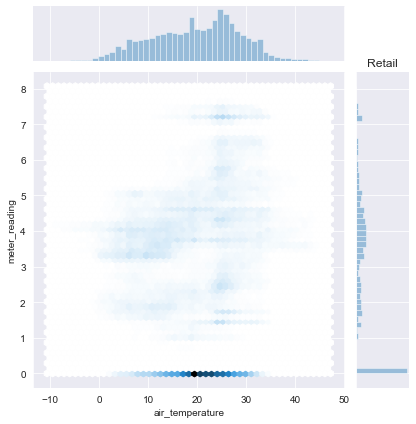

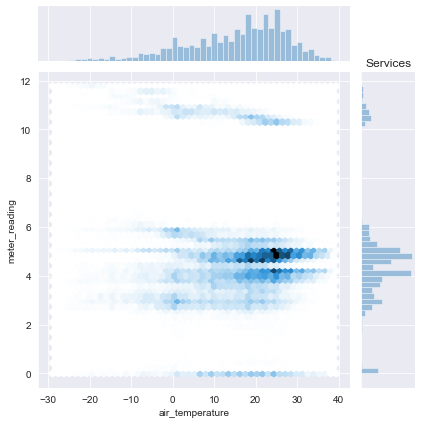

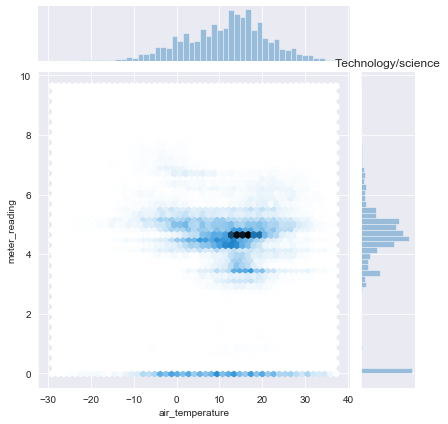

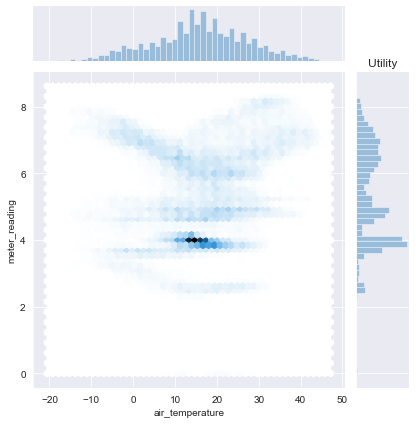

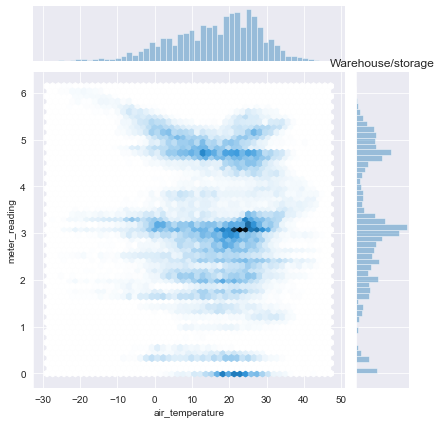

In [31]:
for primary_use, group_df in merged_df.groupby('primary_use'):
    sns.jointplot(data=group_df.assign(meter_reading=np.log1p(group_df.meter_reading)), kind='hex', 
                  x='air_temperature', y='meter_reading')
    plt.title(primary_use)
    plt.show()
    plt.close()

Presumably there are plenty of moments where the various buildings are just not in use and it doesn't matter how hot or cold it is outside. So we should ignore the low `meter_reading` data points. Also, we'll stick to using log-space for meter readings because we've decided that the strong correlation between `square_feet` and `meter_reading` in log-log space is useful for us.

It doesn't look like there's a very clear relationship between the 2 variables. The shape is mostly a blob, but there are density differences in the blob. When split across primary_use, we start to see some patterns for some of the primary usages, but nothing that's very clear. So might be okay to keep the variable in, but I'm not expecting much from it.

### Relationship between `dew_temperature` and `meter_reading`

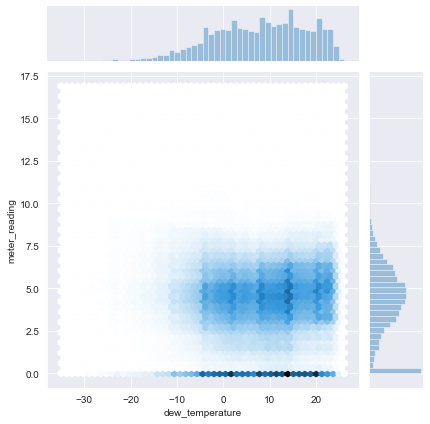

In [32]:
sns.jointplot(data=merged_df.assign(meter_reading=np.log1p(merged_df.meter_reading)), kind='hex',
              x='dew_temperature', y='meter_reading')
plt.show()
plt.close()

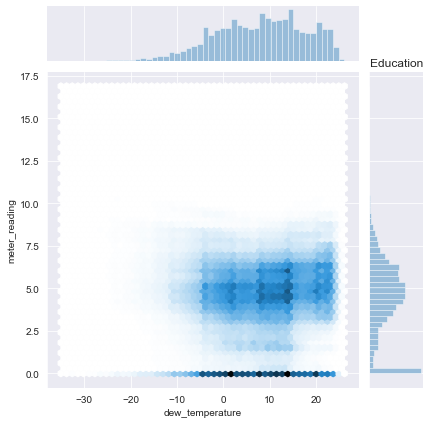

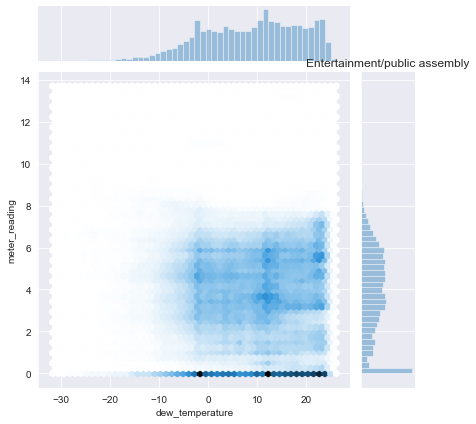

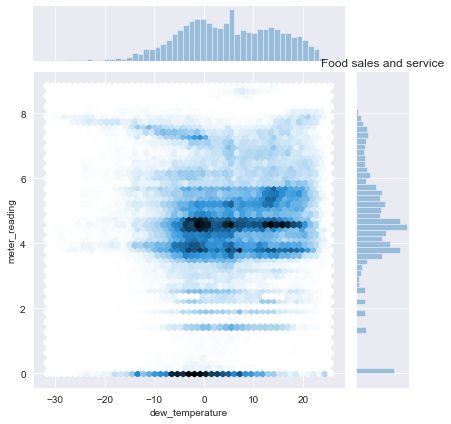

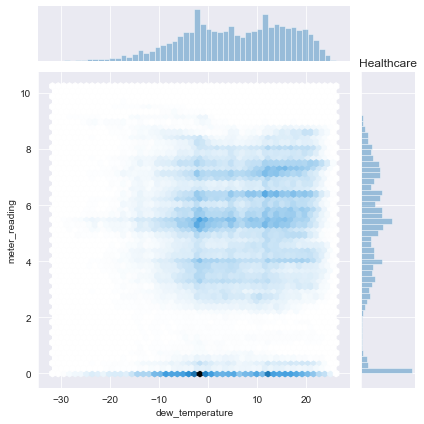

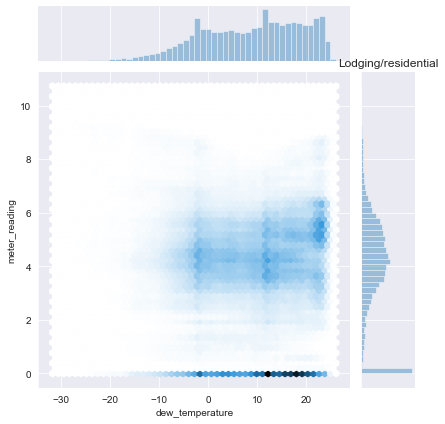

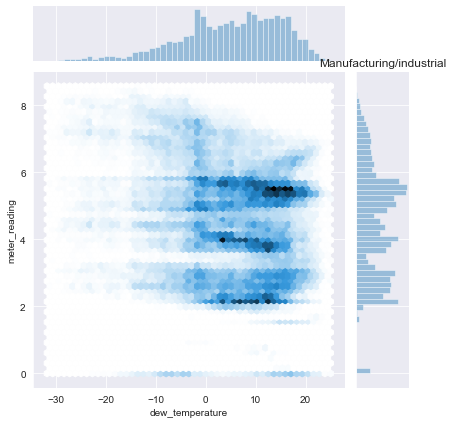

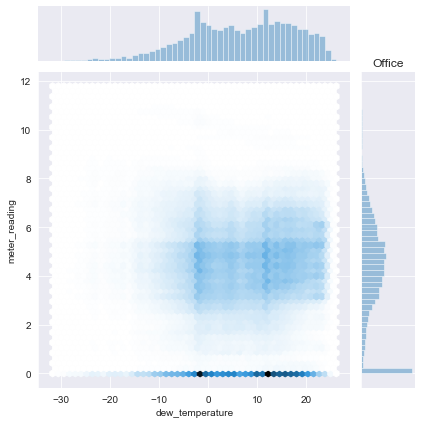

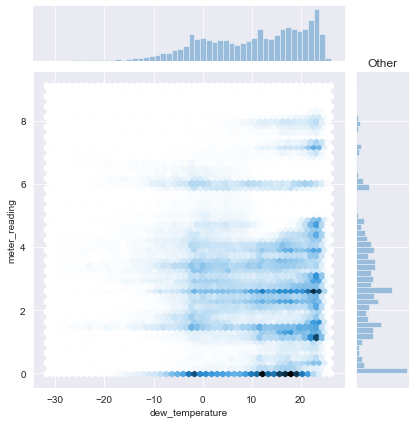

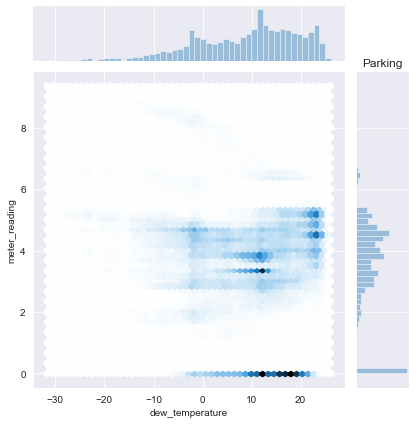

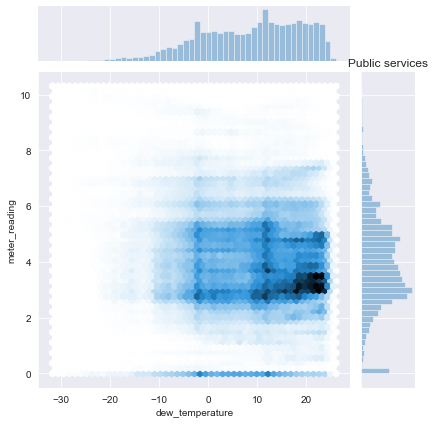

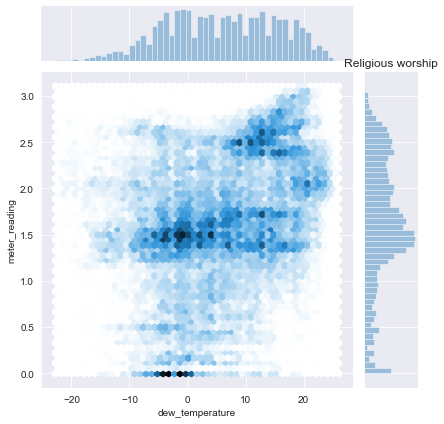

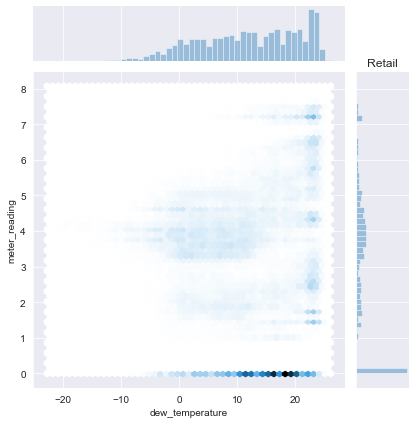

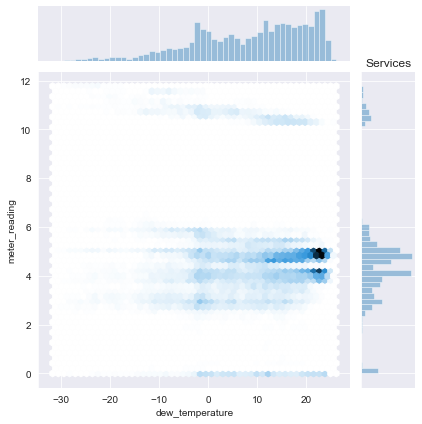

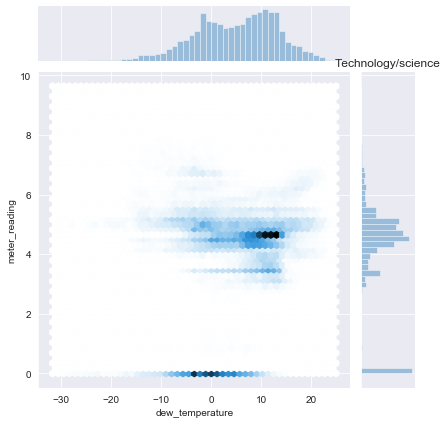

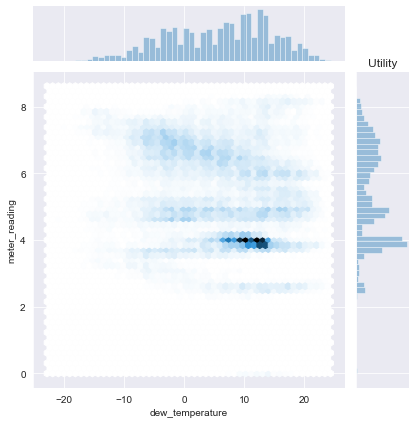

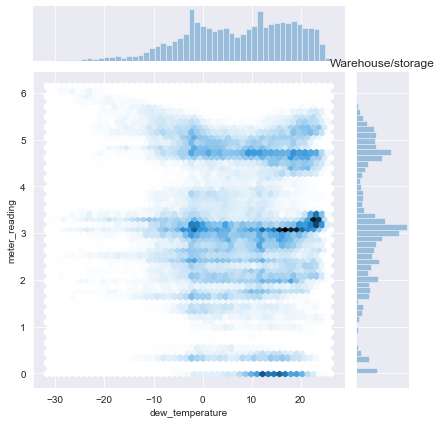

In [33]:
for primary_use, group_df in merged_df.groupby('primary_use'):
    sns.jointplot(data=group_df.assign(meter_reading=np.log1p(group_df.meter_reading)), kind='hex', 
                  x='dew_temperature', y='meter_reading')
    plt.title(primary_use)
    plt.show()
    plt.close()

This whole thing also looks very similar to `air_temperature`. Perhaps worth keeping this in as well, but low expectations.

# Prepare training data

We established earlier that there is value in dealing with the meter_reading in log-space. So we'll do that transformation here as well.

In [34]:
merged_df['meter_reading_log'] = np.log1p(merged_df['meter_reading'])

Of course there are plenty of columns in the `merged_train_df` dataframe that are not required for the actual modeling. So let's select the columns we care for. Let's also make a separate dataframe for testing.

In [35]:
print(sorted(merged_df.columns))

['air_temperature', 'building_id', 'cloud_coverage', 'day_of_week', 'day_of_year', 'dew_temperature', 'floor_count', 'hour_of_day', 'meter', 'meter_reading', 'meter_reading_log', 'precip_depth_1_hr', 'primary_use', 'primary_use_enc', 'sea_level_pressure', 'site_id', 'square_feet', 'square_feet_log', 'timestamp', 'wind_direction', 'wind_speed', 'year_built', 'year_built_enc']


In [36]:
merged_df = merged_df.sort_values('timestamp')
feature_cols = ['building_id', 'day_of_week', 'day_of_year', 'floor_count', 
                'hour_of_day', 'meter', 'primary_use_enc', 'site_id', 
                'square_feet_log', 'year_built_enc', 'air_temperature', 'dew_temperature']
categorical_features = ['building_id', 'day_of_week', 'day_of_year', 'hour_of_day',
                        'meter', 'primary_use_enc', 'site_id', 'year_built_enc']
X_df = merged_df[feature_cols]
y_df = merged_df[['meter_reading_log']]

# LightGBM model

## Train/test split methodology

The training dataset ranges from `2016-01-01 00:00:00` to `2016-12-31 23:00:00` and the test dataset ranges from `2017-01-01 00:00:00` to `2018-12-31 23:00:00`.

So if we split the data for our own train/validation routine, we should also split the data with non-overlapping timestamps. One way to think about it is that the model should learn the day-to-day changes in energy consumption from the seasonality and weather features and not from knowing the changes in energy consumption for the same timestamps for other buildings in the same site.

In [37]:
# We can use `sklearn.model_selection.GroupKFold` and define "groups" to be based on
# the month. Our training dataset has 12 months, and we can choose 3 splits.
kfold = GroupKFold(n_splits=3)
groups = merged_df['timestamp'].dt.month

In [38]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('merged_df', 4460240769),
 ('X_df', 1334262624),
 ('train_df', 788428052),
 ('groups', 323457624),
 ('y_df', 242593224),
 ('group_df', 26846664),
 ('weather_train_df', 5340696),
 ('weather_train_idx', 820562),
 ('building_metadata_df', 231981),
 ('training_datetime_range', 70296),
 ('GroupKFold', 1056),
 ('LabelEncoder', 1056),
 ('building_metadata_enc', 240),
 ('sites', 224),
 ('feature_cols', 160),
 ('primary_use', 138),
 ('describe_df', 136),
 ('load_df', 136),
 ('reduce_mem_usage', 136),
 ('categorical_features', 128),
 ('DATA_DIR', 82),
 ('lgb', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('fig', 56),
 ('g', 56),
 ('kfold', 56)]

In [39]:
# Get rid of other dataframes and save some memory before the real show begins
del train_df
del weather_train_df
del merged_df

import gc
gc.collect()

13004

In [40]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('X_df', 1334262624),
 ('groups', 323457624),
 ('y_df', 242593224),
 ('group_df', 26846664),
 ('weather_train_idx', 820562),
 ('building_metadata_df', 231981),
 ('training_datetime_range', 70296),
 ('GroupKFold', 1056),
 ('LabelEncoder', 1056),
 ('building_metadata_enc', 240),
 ('sites', 224),
 ('feature_cols', 160),
 ('primary_use', 138),
 ('describe_df', 136),
 ('load_df', 136),
 ('reduce_mem_usage', 136),
 ('categorical_features', 128),
 ('DATA_DIR', 82),
 ('lgb', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('fig', 56),
 ('g', 56),
 ('kfold', 56)]

In [41]:
models = []
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    # The actual metric we'd be measured against is RMLSE 
    # (https://www.kaggle.com/c/ashrae-energy-prediction/overview/evaluation)
    # but since we've already taken the log of the meter reading as the target
    # we should just use the RMSE metric.
    "metric": "rmse",
}
for idx, (train_index, val_index) in enumerate(kfold.split(X_df, y_df, groups)):
    print(f'Training fold {idx}')
    X_train_df, y_train_df = X_df.loc[train_index], y_df.loc[train_index]
    X_val_df, y_val_df = X_df.loc[val_index], y_df.loc[val_index]
    train_dataset = lgb.Dataset(X_train_df, label=y_train_df, 
                                categorical_feature=categorical_features)
    val_dataset = lgb.Dataset(X_val_df, label=y_val_df,
                              categorical_feature=categorical_features)
    model = lgb.train(params=params, train_set=train_dataset, num_boost_round=1000,
                      valid_sets=[val_dataset],
                      early_stopping_rounds=50, verbose_eval=25)
    models.append(model)

Training fold 0


/Users/abhinchhabra/.virtualenvs/data/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.79514
[50]	valid_0's rmse: 1.73091
[75]	valid_0's rmse: 1.71133
[100]	valid_0's rmse: 1.69799
[125]	valid_0's rmse: 1.69138
[150]	valid_0's rmse: 1.68865
[175]	valid_0's rmse: 1.68654
[200]	valid_0's rmse: 1.68609
[225]	valid_0's rmse: 1.68587
[250]	valid_0's rmse: 1.68397
[275]	valid_0's rmse: 1.68334
[300]	valid_0's rmse: 1.68287
[325]	valid_0's rmse: 1.68215
[350]	valid_0's rmse: 1.68132
[375]	valid_0's rmse: 1.68004
[400]	valid_0's rmse: 1.67979
[425]	valid_0's rmse: 1.67974
[450]	valid_0's rmse: 1.67969
[475]	valid_0's rmse: 1.67961
[500]	valid_0's rmse: 1.6796
[525]	valid_0's rmse: 1.67959
[550]	valid_0's rmse: 1.67951
[575]	valid_0's rmse: 1.67953
[600]	valid_0's rmse: 1.67947
[625]	valid_0's rmse: 1.67944
[650]	valid_0's rmse: 1.67944
[675]	valid_0's rmse: 1.67945
Early stopping, best iteration is:
[633]	valid_0's rmse: 1.67943
Training fold 1
Training until validation scores don't improve for 5

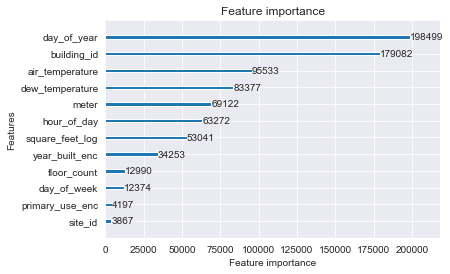

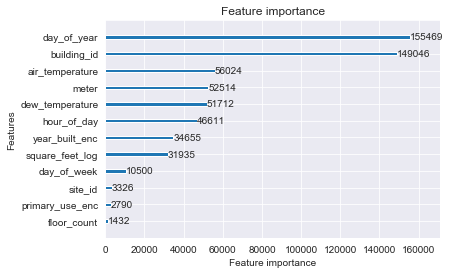

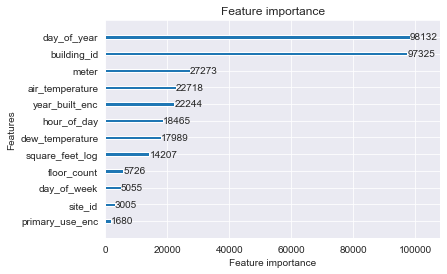

In [42]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [43]:
print(np.mean([model.best_score['valid_0']['rmse'] for model in models]))

1.5991038111166176


# Evaluating the model on the test data

In [44]:
# Load the test dataframes first
test_df = reduce_mem_usage(load_df('test.csv'))
weather_test_df = reduce_mem_usage(load_df('weather_test.csv'))

Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [45]:
gc.collect()

12045

In [46]:
test_df = test_df.assign(hour_of_day=test_df['timestamp'].dt.hour, 
                         day_of_week=test_df['timestamp'].dt.dayofweek,
                         day_of_year=test_df['timestamp'].dt.dayofyear)

merged_test_df = (test_df
                  .merge(building_metadata_df, how='left', on=['building_id'])
                  .merge(weather_test_df, how='left', on=['site_id', 'timestamp']))
X_test_df = merged_test_df[feature_cols]
row_ids = merged_test_df['row_id']

In [47]:
del test_df
del weather_test_df
del merged_test_df
gc.collect()

63

In [48]:
describe_df(X_test_df)

Shape of data:  (41697600, 12)

Basic info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 12 columns):
building_id        int16
day_of_week        int64
day_of_year        int64
floor_count        float16
hour_of_day        int64
meter              int8
primary_use_enc    int64
site_id            int8
square_feet_log    float64
year_built_enc     int64
air_temperature    float16
dew_temperature    float16
dtypes: float16(3), float64(1), int16(1), int64(5), int8(2)
memory usage: 2.6 GB
None

Quick peek at the data:
   building_id  day_of_week  day_of_year  floor_count  hour_of_day  meter  \
0            0            6            1          NaN            0      0   
1            1            6            1          NaN            0      0   
2            2            6            1          NaN            0      0   
3            3            6            1          NaN            0      0   
4            4            6            

In [49]:
results = sum(np.expm1(model.predict(X_test_df)) / len(models) 
              for model in models)
results_df = pd.DataFrame({'row_id': row_ids, 
                           'meter_reading': np.clip(results, 0, None)})
results_df.head()

,row_id,meter_reading
0,0,4.273809
1,1,4.213870
2,2,4.694459
3,3,5.381230
4,4,24.993851


In [50]:
results_df.to_csv('submission.csv', index=False, float_format='%.4f')

# Notes

* Why encode year_built? Isn't it already encoded?
* Play around with imputing the empty features for the weather data
* Play around with month of year vs. day of year
* Consider converting site 0 readings to kWh just like the rest
* Maybe floor count should be categorical?